In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  floa

In [4]:
coluna_target = ["median_house_value"]

coluna_one_hot_encoder = ["ocean_proximity"]

coluna_ordinal_encoder = ["median_income_cat"]

In [5]:
colunas_robust_scaler = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder)

colunas_robust_scaler

Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object')

In [6]:
pipeline_robust = Pipeline(steps=[
    ("robust_scaler", RobustScaler()),
    ("poly", PolynomialFeatures(degree=1, include_bias=False))
])

preprocessamento = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), coluna_ordinal_encoder),
        ("one_hot", OneHotEncoder(drop="first"), coluna_one_hot_encoder),
        ("robust_scaler_poly", pipeline_robust, colunas_robust_scaler),
    ],
)

In [7]:
X = df.drop(columns=coluna_target)
y = df[coluna_target]

In [8]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,NEAR BAY,2,5.343676,2.362768,0.203216


In [9]:
y.head()

,median_house_value
0,452600
1,358500
2,226700
3,140000
4,158700


GridSearch para avaliar target

In [11]:
param_grid = {
    "regressor__preprocessor__robust_scaler_poly__poly__degree": [1, 2, 3],
    "regressor__reg__alpha": [1E-2, 5E-2, 0.1, 0.25, 0.5, 1.0],
    "regressor__reg__l1_ratio": [0.1, 0.25, 0.5, 0.75, 0.9],
}

In [12]:
grid_search = grid_search_cv_regressor(
    regressor=ElasticNet(),
    preprocessor=preprocessamento,
    target_transformer=QuantileTransformer(output_distribution="normal"),
    param_grid=param_grid,
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               Ro...
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0],
                         'regressor__reg__l1_ratio': [0.1, 0.25, 0.5, 0.75,
                                                      0.9]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [13]:
grid_search.fit(X, y)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


C:\Users\junio\anaconda3\envs\machine_learning\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
C:\Users\junio\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.382e+02, tolerance: 1.757e+00
  model = cd_fast.enet_coordinate_descent(


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               Ro...
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3],
                         'regressor__reg__alpha': [0.01, 0.05, 0.1, 0.25, 0.5,
                                                   1.0],
                         'regressor__reg__l1_ratio': [0.1, 0.25, 0.5, 0.75,
                                                      0.9]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [14]:
grid_search.best_params_

{'regressor__preprocessor__robust_scaler_poly__poly__degree': 3,
 'regressor__reg__alpha': 0.01,
 'regressor__reg__l1_ratio': 0.1}

resultado 'regressor__reg__alpha': 0.01, é 'regressor__reg__l1_ratio': 0.1
<br>
Por está com resultado baixo esta mais próximo do Ridge 

In [16]:
grid_search.best_score_

np.float64(-51305.06563354598)

In [17]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_["reg"].coef_,
    grid_search.best_estimator_.regressor_["preprocessor"].get_feature_names_out(),
)

coefs

,coeficiente
one_hot__ocean_proximity_INLAND,-0.599732
robust_scaler_poly__longitude,-0.380433
robust_scaler_poly__population_per_household,-0.340582
robust_scaler_poly__latitude,-0.211205
robust_scaler_poly__latitude^2,-0.193619
...,...
ordinal_encoder__median_income_cat,0.092195
robust_scaler_poly__housing_median_age longitude^2,0.106619
robust_scaler_poly__bedrooms_per_room,0.129028
robust_scaler_poly__housing_median_age median_income,0.179321


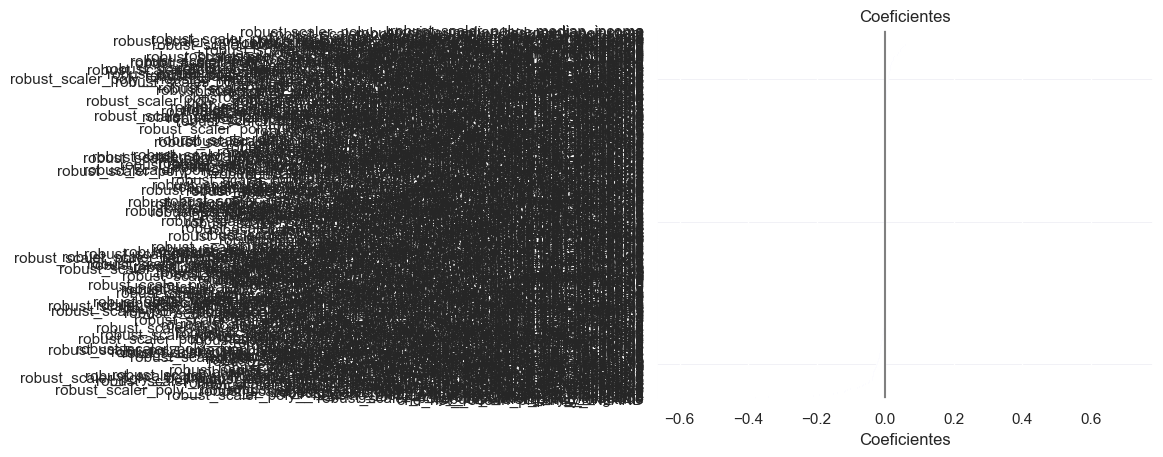

In [18]:
plot_coeficientes(coefs)

In [19]:
coefs[coefs["coeficiente"] == 0]

,coeficiente
robust_scaler_poly__population_per_household total_rooms^2,0.0
robust_scaler_poly__population_per_household total_bedrooms total_rooms,0.0
robust_scaler_poly__population_per_household total_bedrooms^2,0.0
robust_scaler_poly__population_per_household rooms_per_household total_bedrooms,-0.0
robust_scaler_poly__total_rooms^3,0.0
...,...
robust_scaler_poly__longitude total_bedrooms^2,-0.0
robust_scaler_poly__longitude rooms_per_household total_bedrooms,0.0
robust_scaler_poly__longitude rooms_per_household total_rooms,0.0
robust_scaler_poly__total_rooms,0.0


In [20]:
coefs[coefs["coeficiente"].between(-0.1, 0.1) & (coefs["coeficiente"] != 0)]

,coeficiente
robust_scaler_poly__bedrooms_per_room^2 median_income,-0.081365
robust_scaler_poly__bedrooms_per_room^2 latitude,-0.075550
robust_scaler_poly__median_income^2,-0.066034
robust_scaler_poly__housing_median_age latitude,-0.065313
robust_scaler_poly__median_income population_per_household,-0.058787
...,...
robust_scaler_poly__total_bedrooms,0.074941
robust_scaler_poly__housing_median_age population_per_household^2,0.083903
robust_scaler_poly__housing_median_age,0.087634
robust_scaler_poly__median_income total_bedrooms,0.091257


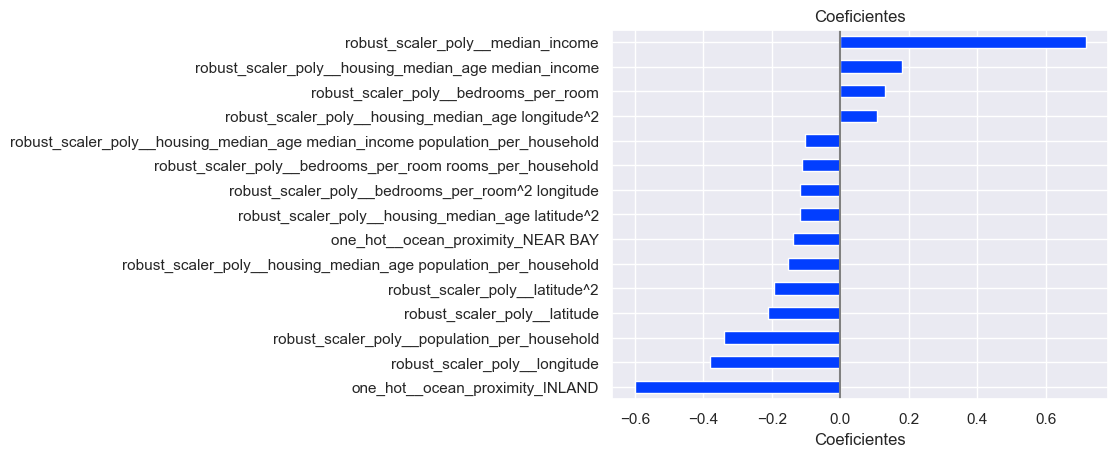

In [21]:
plot_coeficientes(coefs[~coefs["coeficiente"].between(-0.1, 0.1)])

In [22]:
regressors = {
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    "LinearRegression": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    "LinearRegression_target": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": QuantileTransformer(output_distribution="normal"),
    },
    "ElasticNet_grid_search": {
        "preprocessor": grid_search.best_estimator_.regressor_["preprocessor"],
        "regressor": grid_search.best_estimator_.regressor_["reg"],
        "target_transformer": grid_search.best_estimator_.transformer_,
    },
}


resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

C:\Users\junio\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.450e+01, tolerance: 1.437e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\junio\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.957e+01, tolerance: 1.455e+00
  model = cd_fast.enet_coordinate_descent(
C:\Users\junio\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or co

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.01531,0.011941,-0.000081,-77516.042766,-96239.705692,0.027251
1,DummyRegressor,0.006801,0.008771,-0.000146,-75787.787194,-95217.629397,0.015573
2,DummyRegressor,0.005902,0.006904,-0.001737,-76753.598961,-96253.253947,0.012806
3,DummyRegressor,0.005226,0.007563,-0.000101,-76837.804811,-95983.885799,0.012789
4,DummyRegressor,0.006378,0.006546,-0.000114,-76617.245449,-96182.764729,0.012925
5,LinearRegression,0.082687,0.023176,0.682162,-39855.690996,-54254.958188,0.105864
6,LinearRegression,0.053741,0.023845,0.66999,-40272.565467,-54695.230283,0.077586
7,LinearRegression,0.060766,0.023064,0.649247,-42178.05929,-56955.988706,0.08383
8,LinearRegression,0.067599,0.024148,0.669873,-40806.492497,-55146.318803,0.091747
9,LinearRegression,0.061105,0.020445,0.669023,-40788.496497,-55331.35106,0.081551


In [23]:
df_resultados.groupby("model").mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.007924,0.008345,-0.000436,-76702.495836,-95975.447913,0.016269
ElasticNet_grid_search,8.286578,0.048287,0.714036,-36003.331142,-51294.899367,8.334864
LinearRegression,0.06518,0.022936,0.668059,-40780.26095,-55276.769408,0.088115
LinearRegression_target,0.073065,0.025271,0.678488,-38675.469595,-54397.566578,0.098336


In [24]:
df_resultados.groupby("model").mean().sort_values(by="test_neg_root_mean_squared_error")

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.007924,0.008345,-0.000436,-76702.495836,-95975.447913,0.016269
LinearRegression,0.06518,0.022936,0.668059,-40780.26095,-55276.769408,0.088115
LinearRegression_target,0.073065,0.025271,0.678488,-38675.469595,-54397.566578,0.098336
ElasticNet_grid_search,8.286578,0.048287,0.714036,-36003.331142,-51294.899367,8.334864


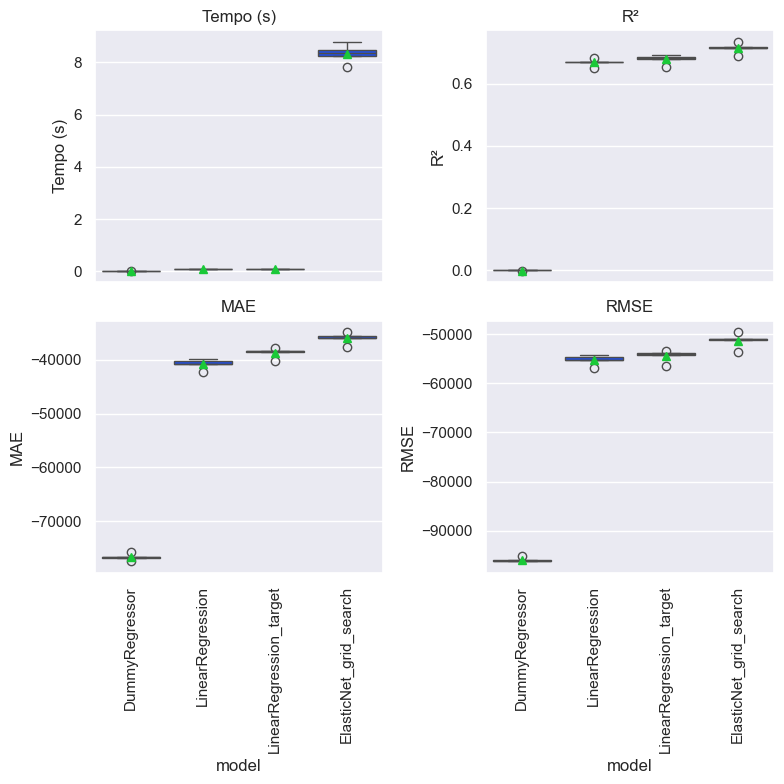

In [25]:
plot_comparar_metricas_modelos(df_resultados)

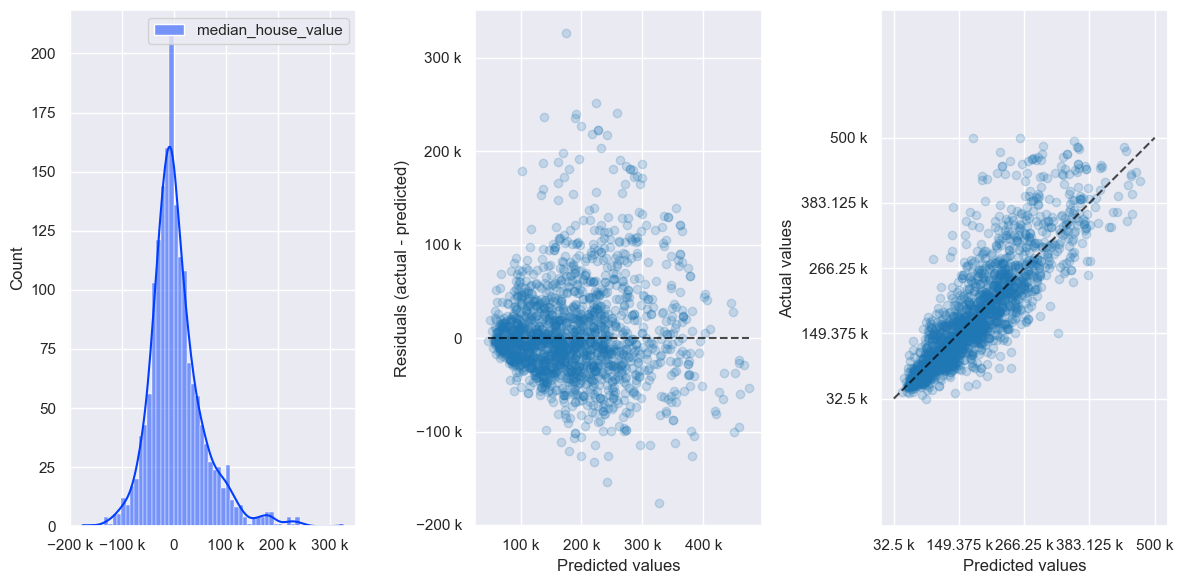

In [26]:
plot_residuos_estimador(
    grid_search.best_estimator_, X, y, 
    fracao_amostra=0.1, # fração da amostrar
    eng_formatter=True, # escala y para organizador
)